# CSE 549 Project: Uncertainty Quantification 

#### Team: 

* 111742914 (Syed Fahad Sultan)
* 111482304 (Anjul Kumar Tyagi)
* 111753053 (Arjun Krishna)
* 111447392 (Rohit Rao P)

## Table of Content<a id="toc"></a>

<hr>
1. [Data Preparation](#dataprep)
    1. [Reading Data](#reading) 
    2. [Computing basic second order bootstrap variables](#secondorder)
    3. [Creating binary label for valid/invalid transcripts](#validinvalid)
    4. [Creating a continuous measure of quality of output](#continuous)
    5. [Merging Data](#merging)
2. [Analysis](#observations)
    1. [Percentage of Invalid transcripts](#percentageinvalid)
    2. [Valid transcripts have smaller truth values](#smallertruth)
    3. [Relationship between truth values and mean of the estimates](#truth_mean)
    4. [Variance of the estimates for valid/invalid transcripts](#std_mean)
    5. [Length and EffectiveLength for valid and invalid transcripts is very similar](#lengths)
    6. [TPM and Number of Reads has considerable variance for valid and invalid transcripts](#tpmnumreads)
    7. [Salmon often underestimates the count, but its overestimates are huge](#overestimates)
    8. [Mean Absolute Percentage Error for valid/invalid transcripts](#mape)
    9. [NumReads and Mean Error](#numreadserror)
    7. [Normalized Mean Absolute Error for valid/invalid transcripts](#normalizedmeanerror)
    8. [Relationship of Mean Error with Length, EffectiveLength, TPM and Number of Reads](#mae_attr)
    9. [Valid and invalid transcripts often found together in equivalent classes](#makeupeclasses)
    10. [Invalid transcripts belong to a larger number of equivalent classes as compared to valid transcripts](#noofclasses)
    11. [Sum of numreads weighted by size of equivalent classes it belongs to](#weightedreads)
    11. [Sum of NumReads divided by Number of Equivalent Classes](#something)
3. [Predicting Valid/Invalid transcripts](#classification)
    1. [Predicting valid/invalid transcripts using binary classification](#binaryclassification)
    2. [Predicting mean error using regression](#regression)

<hr>

[Go to top](#toc)

## 1. DATA PREPARATION<a id="dataprep"></a>

### 1.A. Reading Data<a id="reading"></a>

Python has **Pandas** library for effectively dealing with data. We'll use Pandas for working with the given data and **Numpy** for data manipulations. For plotting graphics, we've used **Matplotlib** library. 

Reading bootstrap, truth values, and quant.sf files as pandas dataframes:

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import math

# Read the Bootstrap samples
data = pd.read_csv('data/poly_mo/quant_bootstraps.tsv', header=0, sep='\t')
# Read the truth values for each transcript
truth = pd.read_csv('data/poly_mo/poly_truth.tsv', header=0, index_col=0, sep='\t')
# Read the properties file for each transcript
quant = pd.read_csv('data/poly_mo/quant.sf', header=0, index_col=0, sep='\t')

Reading and parsing **equivalence classes** file:

In [2]:
lines = []
with open('data/poly_mo/eq_classes.txt') as f:
    lines = f.readlines()

lines = [line.replace('\n', '') for line in lines]

transcripts_count = int(lines[0])

transcripts = lines[2:transcripts_count+2]
classes = lines[transcripts_count+2:]

classes = [datum.split('\t') for datum in classes]

Creating a pandas dataframe for Equivalence classes:

In [3]:
unraveled = []

for i, eclass in enumerate(classes):
    for ts_idx in eclass[1:-1]:
        unraveled.append((i, int(eclass[0]), transcripts[int(ts_idx)], int(eclass[-1])))
        
eq_df = pd.DataFrame().from_dict(unraveled)
eq_df.columns=['eclass_id', 'eclass_size', 'transcript', 'numreads']

<hr>
[Go to top](#toc)
### 1.B. Computing basic second order boostrap variables <a id="secondorder"></a>

For each transcript, some basic statistics from the bootstrap such as min, max, mean and standard deviation.

In [4]:
data = data.apply(lambda x: np.sort(x.values))

data_mins = data.min()
data_maxs = data.max()
data_means = data.mean()
data_std = data.std()

<hr>
[Go to top](#toc)
### 1.B. Creating binary label for valid/invalid transcripts <a id="validinvalid"></a>

Computing the **95% confidence interval** for each transcript from the given bootstrap samples. For this operation, the bootstrap samples are sorted for each transcript and then the lower and upper quartiles are computed. 

All the computed lower and upper bounds are stored in the data frame.

In [5]:
lower_bounds = data.apply(lambda values: values[int(math.ceil(0.025*len(values)))])
upper_bounds = data.apply(lambda values: values[int(math.floor(0.975*len(values)))])

data = data.transpose()

data['truth'] = truth

data = data[~data['truth'].isnull()]

data['lower_bound'] = lower_bounds
data['upper_bound'] = upper_bounds

data['invalid'] = data.apply(
    lambda x: (x['truth'] < x['lower_bound']) or (x['upper_bound'] < x['truth']), axis=1)

In [6]:
data['min'] = data_mins
data['max'] = data_maxs
data['mean'] = data_means
data['std'] = data_std

<hr>
[Go to top](#toc)
### 1.C. Creating continuous measure of quality of output <a id="continuous"></a>

As shown in the [Observation 2.A.](#percentageinvalid), the classification based on the confidence interval classifies around **50%** of the transcripts as invalid, which is a very big number. This results clearly shows that this classification isn't good. 
An alternative to binary classification is the **continuous classification** with **normalized Mean absolute error** as a measure of goodness of a transcript.

In the step below, the error of each boostrap prediction is calculated by measuring it's distance from the truth value and taking the arithmetic mean of the distance.

In [7]:
BOOTSTRAP_RUNS = 200

def get_mean_absolute_percentage_error(row):
    truth = row['truth']
    errors = [(truth-a_count)/truth for a_count in row[:BOOTSTRAP_RUNS]]
#     errors_percentage = np.mean(np.abs(errors))*100
    errors_percentage = np.mean((errors))*100
    return errors_percentage

data['mape'] = data.apply(get_mean_absolute_percentage_error, axis=1)

Normalizing the mean error with the range of the confidence interval for each transcript.

In [8]:
data['mae_n'] = data.apply(lambda x: (x['truth']-np.mean(x[:BOOTSTRAP_RUNS]))/(x['max']-x['min']+1) ,axis=1)

<hr>
[Go to top](#toc)
### 1.D. Merging Data <a id="merging"></a>

Merging the attributes from quant.sf with the data boostrap and groundtruth data:

In [9]:
data['Length'] = quant['Length']
data['EffectiveLength'] = quant['EffectiveLength']
data['TPM'] = quant['TPM']
data['NumReads'] = quant['NumReads']

Merging equivalent classes dataframe with the data:

In [10]:
merged = pd.merge(eq_df, data[['invalid', 'min', 'max', 'mean', 'std', 'truth', 'mape', 'mae_n']].drop_duplicates(), left_on='transcript', right_index=True)

In [11]:
merged2 = pd.merge(merged, quant, left_on='transcript', right_index=True)

Here is what the dataframe with all the merged data looks like:

In [12]:
merged2.head()

,eclass_id,eclass_size,transcript,numreads,invalid,min,max,mean,std,truth,mape,mae_n,Length,EffectiveLength,TPM,NumReads
0,0,1,ENST00000375898,385,True,329.000000,434.000000,386.985000,19.682014,462,16.237013,0.707689,5338,5138.991,2.305557,385.000000
2,1,4,ENST00000563559,47,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488
89810,24518,5,ENST00000563559,25,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488
101516,27786,5,ENST00000563559,657,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488
127144,34956,3,ENST00000563559,25,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488


In [13]:
merged2.head()

,eclass_id,eclass_size,transcript,numreads,invalid,min,max,mean,std,truth,mape,mae_n,Length,EffectiveLength,TPM,NumReads
0,0,1,ENST00000375898,385,True,329.000000,434.000000,386.985000,19.682014,462,16.237013,0.707689,5338,5138.991,2.305557,385.000000
2,1,4,ENST00000563559,47,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488
89810,24518,5,ENST00000563559,25,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488
101516,27786,5,ENST00000563559,657,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488
127144,34956,3,ENST00000563559,25,True,1271.113536,1481.382832,1381.305323,37.884988,1473,6.225029,0.434018,2128,1928.991,22.055163,1382.443488


<hr>
[Go to top](#toc)
## 2. ANALYSIS<a id="observations"></a>

In this section, we discuss our analysis and share all of our interesting observations

In [22]:
from math import log

from matplotlib import pyplot as plt, rc

plt.rcParams['figure.figsize'] = (15, 6) 
# fig.set_size_inches(15,10)

%matplotlib inline

### 2.A. Percentage of Invalid transcripts in the dataset<a id="percentageinvalid"></a>

**Fifty percent** of the transcripts in the bootstrap file, for which the ground truth is also available, are invalid. 

This is for the data in the **poly_mo** folder. For the **poly_ro** folder, the number of invalid transcripts was around **80 percent**. 

Because of the better balance between valid and invalid transcripts, all the following analysis was conducted for the  **poly_mo** folder. 

In [97]:
print "Percentage of invalid rows: %s percent" % \
    (float(sum(data['invalid'])*100)/data.shape[0])

Percentage of invalid rows: 50.2547510134 percent


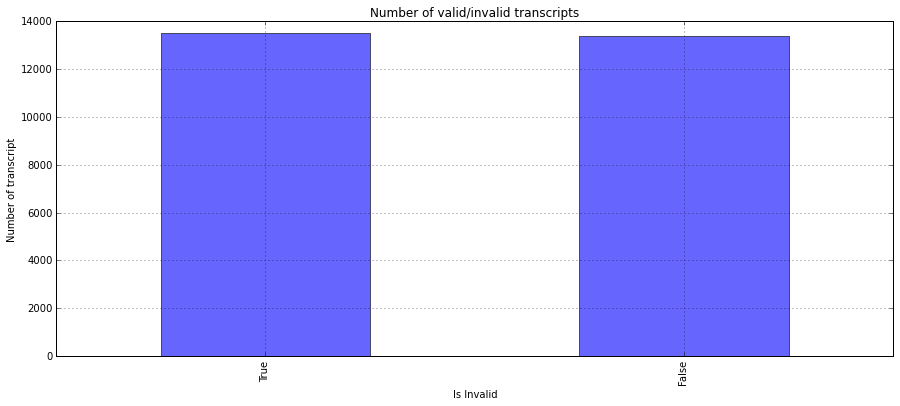

In [118]:
data['invalid'].value_counts().plot(kind='bar', alpha=0.6)
plt.title('Number of valid/invalid transcripts')
plt.xlabel('Is Invalid')
t = plt.ylabel('Number of transcript')

<hr>
[Go to top](#toc)
### 2.B. Valid transcripts tend to have smaller truth values<a id="smallertruth"></a>

Salmon appears to do a better job for transcripts that have smaller truth values. This statistic is aligned with the information in the project description stating that Salmon often tends to underestimate the count. 

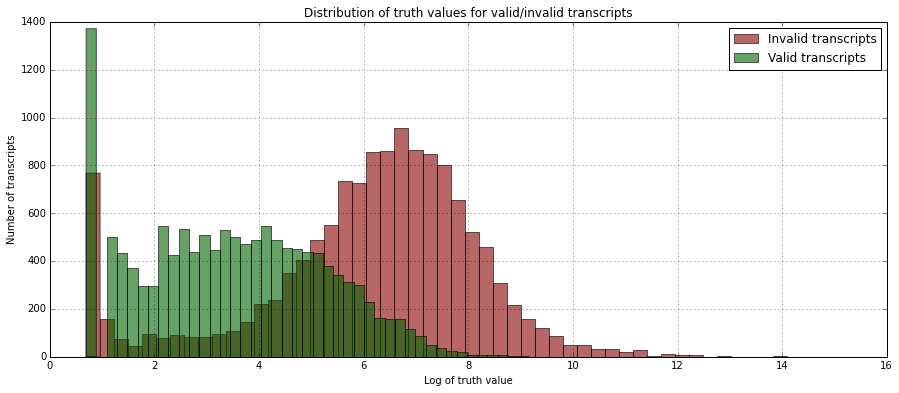

In [119]:
plt.rcParams['figure.figsize'] = (15, 6) 

data[data['invalid']]['truth'].apply(lambda x: log(x+1)).hist(alpha=0.6, bins=50, color='darkred')
data[~data['invalid']]['truth'].apply(lambda x: log(x+1)).hist(alpha=0.6, bins=50, color='darkgreen')
plt.xlabel('Log of truth value')
plt.ylabel('Number of transcripts')
plt.legend(['Invalid transcripts', 'Valid transcripts'])
t = plt.title('Distribution of truth values for valid/invalid transcripts')

<hr>
[Go to top](#toc)
<a id="truth_mean"></a>

### 2.C. Relationship between the truth values and the mean of the estimates

We looked at the relationship between mean of the estimates and the truth value. 

It turns out that the **mean** has the same distribution as the **truth values** but is slightly shifted to the left. This reaffirms the fact that the estimates often underestime the true count.

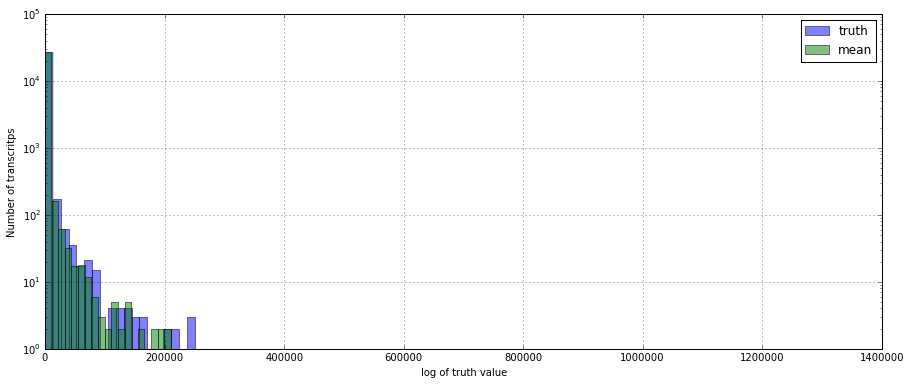

In [32]:
data['truth'].hist(log=True, alpha=0.5, bins=100)
data['mean'].hist(log=True, alpha=0.5, bins=100)
plt.legend(['truth','mean'])
plt.xlabel('log of truth value')
plt.ylabel('Number of transcritps')

<hr>
[Go to top](#toc)
<a id="std_mean"></a>

### 2.D. Variance of Salmon's estimated count for valid/invalid transcripts

Interestingly, the variance in Salmon's estimates is more for invalid trancripts as compared to for valid transcripts. 

This means Salmon is more confident for 

Plot for the distribution of **standard deviation** for valid and invalid transcripts.

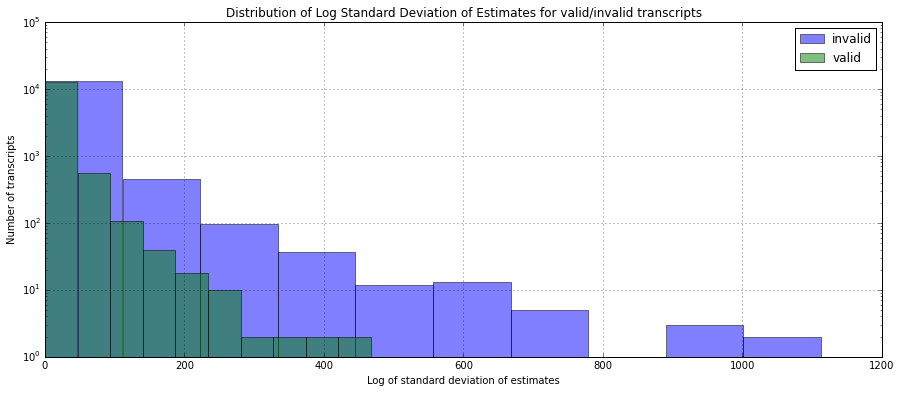

In [137]:
data[data['invalid']]['std'].hist(log=True, alpha=0.5)
data[~data['invalid']]['std'].hist(log=True, alpha=0.5)
plt.legend(['invalid', 'valid'])
plt.xlabel('Log of standard deviation of estimates')
plt.ylabel('Number of transcripts')
t = plt.title('Distribution of Log Standard Deviation of Estimates for valid/invalid transcripts')

<hr>
[Go to top](#toc)
<a id="lengths"></a>
### 2.E. Valid and Invalid transcripts show little variance w.r.t 'Length' and 'Effective Length' features

Valid and Invalid transcripts, it appears, have similar Length and EffectiveLength values.

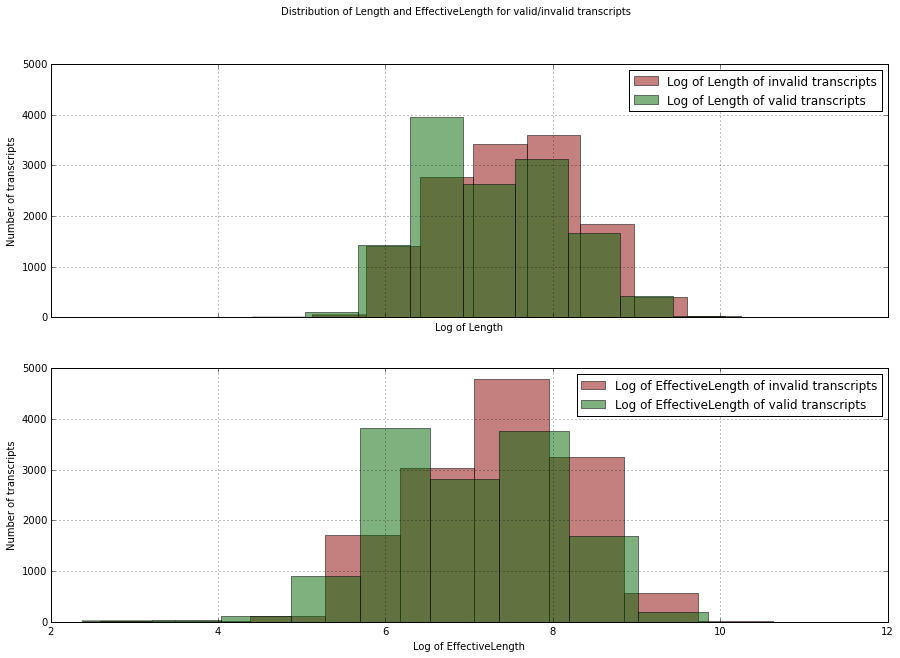

In [120]:
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength']

for i, prop in enumerate(properties):
    ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkred')
    ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.5, color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])
    axs[i].set_ylabel('Number of transcripts')
    axs[i].set_xlabel('Log of %s' % prop)
    
t = plt.suptitle('Distribution of Length and EffectiveLength for valid/invalid transcripts')

<hr>
[Go to top](#toc)
<a id="tpmnumreads"></a>
### 2.F. Valid and Invalid transcripts exhibit variance w.r.t 'TPM' and 'NumReads'.

Valid and invalid transcripts show considerable variance with respect to TPM and NumReads. It follows that these two are going to be important features in trying to predict beforehand the quality of the count estimate for transcripts.

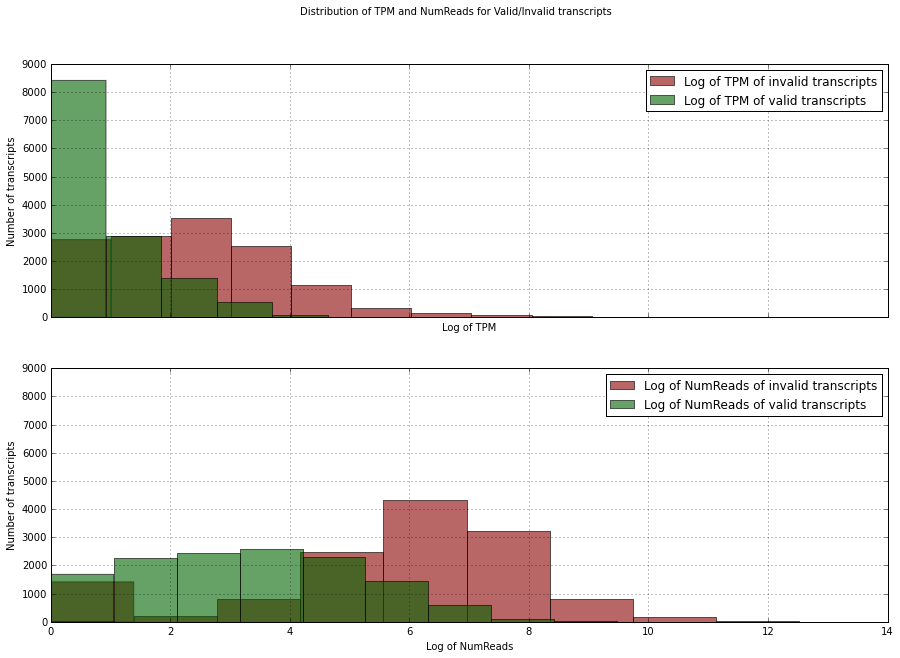

In [121]:
fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['TPM', 'NumReads']

for i, prop in enumerate(properties):
    ax = data[data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkred')
    ax = data[~data['invalid']][prop].apply(lambda x: log(x+1)).hist(ax=axs[i], alpha=0.6, color='darkgreen')
    ax.legend(['Log of %s of invalid transcripts' % prop, 'Log of %s of valid transcripts' % prop])
    ax.set_ylabel('Number of transcripts')
    ax.set_xlabel('Log of %s' % prop)
    
t = plt.suptitle('Distribution of TPM and NumReads for Valid/Invalid transcripts')

<hr>
[Go to top](#toc)
<a id="overestimates"></a>

### 2.G. Bootstrapping generally underestimates the count, but when it overestimates, the transcripts are very highly overestimated.

The graph below shows that most estimations are close to **0**, i.e. the estimates have some error. However, there are some outliers so far away from origin showing that they're so highly overestimated.

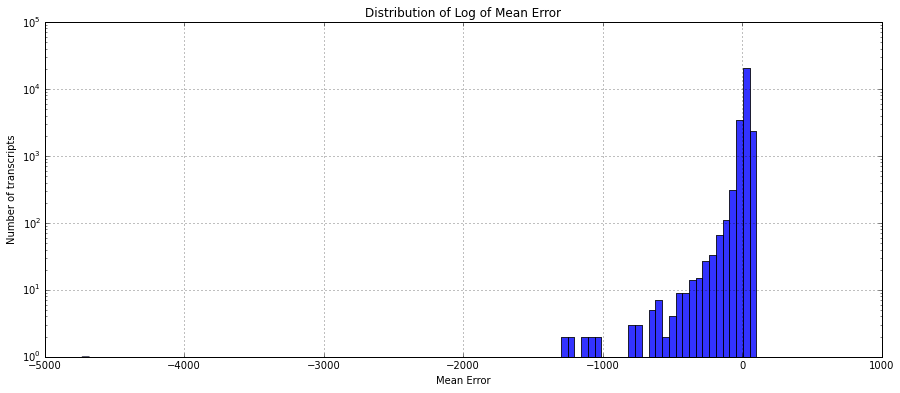

In [130]:
plt.rcParams['figure.figsize'] = (15, 6) 
fig.set_size_inches(15,10)

data['mape'].hist(log=True, bins=100, alpha=0.8)
plt.title('Distribution of Log of Mean Error')
plt.xlabel('Mean Error')
t = plt.ylabel('Number of transcripts')

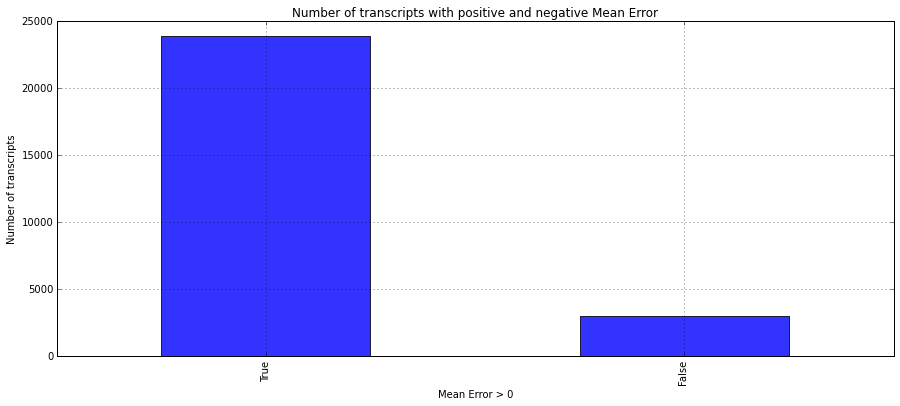

In [129]:
(data['mape']>0).value_counts().plot(kind='bar', alpha=0.8)
plt.xlabel('Mean Error > 0')
plt.ylabel('Number of transcripts')
t = plt.title('Number of transcripts with positive and negative Mean Error ')

<hr>
[Go to top](#toc)
<a id="mape"></a>
### 2.H. Mean Absolute Percentage Error for valid/invalid transcripts

We had **valid** and **invalid** transcripts in the discrete domain calculated based on the confidence intervals from the bootstrap samples. However, as with all hard thresholds, the choice of 95 percent confidence interval criteria for validity is somewhat arbitrary. Therefore, we computed **continuous error** measure. 

The plot below shows the evaluation of the **mean absolute percentage error** of both **valid and invalid** transcripts.

Interestingly, valid and invalid transcripts don't exhibit distinctive distributions. 

This suggests that many transcripts are considered **valid** because the groundtruth value falls close to the edge of the bounds of the confidence interval. 

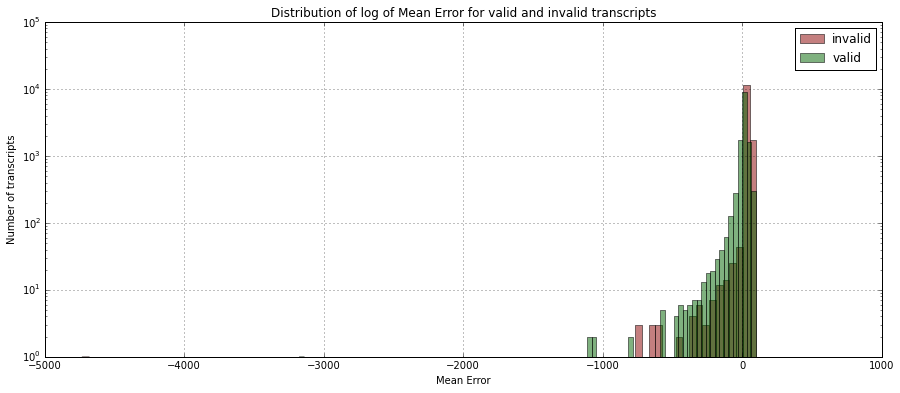

In [131]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) 
data[data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100, color='darkred')
data[~data['invalid']]['mape'].hist(log=True, alpha=0.5, bins=100, color='darkgreen')
plt.legend(['invalid', 'valid'])
plt.title('Distribution of log of Mean Error for valid and invalid transcripts')
plt.xlabel('Mean Error')
t = plt.ylabel('Number of transcripts')

<hr>
[Go to top](#toc)
<a id="numreadserror"></a>
### 2.I. NumReads and Mean Error 

As observed from the data, **Num Reads** acts as an important predictor for **valid** and **invalid** transcripts. It'll be interesting to know the **correlation** between the **Mean percentage error** and **Num Reads**.

In [30]:
pearsonr(abs(data['mape']), data['NumReads'])

(-0.016308857737198885, 0.0074872451768554678)

The correlation value of **-0.0025** shows that Num Reads and Mean Absolute percentage error are very slightly correlated if at all.
The plot below shows the **Mean absolute percentage error** for **Num Reads**.

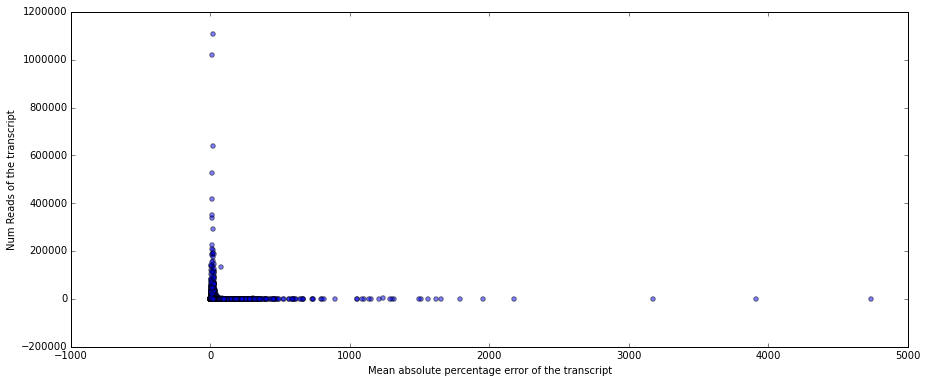

In [31]:
properties = ['TPM', 'NumReads']
plt.scatter(data['mape'].apply(lambda x: np.abs(x)), data['NumReads'], alpha=0.5)
plt.xlabel('Mean absolute percentage error of the transcript')
plt.ylabel('Num Reads of the transcript')

<hr>
[Go to top](#toc)
<a id=normalizedmeanerror></a>

### 2.J. Normalized Mean Error for valid and invalid transcripts

After normalization, there's a clear distinction between the valid and invalid transcripts. 

Valid ones are almost very close to zero but invalid are scattered in a big range.

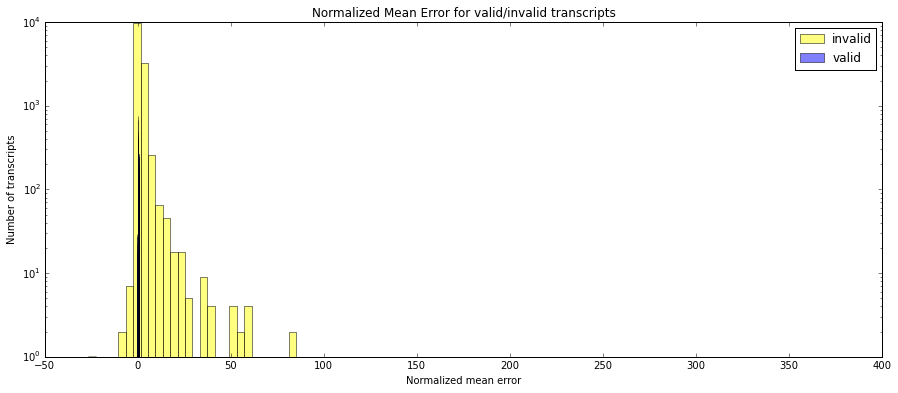

In [133]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) 
data[data['invalid']]['mae_n'].hist(log=True, alpha=0.5, bins=100, color='yellow')
data[~data['invalid']]['mae_n'].hist(log=True, alpha=0.5, bins=100, color='blue')
plt.legend(['invalid', 'valid'])
plt.grid(False)
plt.xlabel('Normalized mean error')
plt.ylabel('Number of transcripts')
t = plt.title('Normalized Mean Error for valid/invalid transcripts')

<hr>
[Go to top](#toc)
<a id="mae_attr"></a>
### 2.K. Relationship between mean error normalized and (Length, Effective Length, TPM and NumReads)

Weirdly enough, even though normalized mean error is expectedly very distinct for valid and invalid transcripts, it's relationship with TPM and NumReads as not as clear as for the binary valid/invalid label.

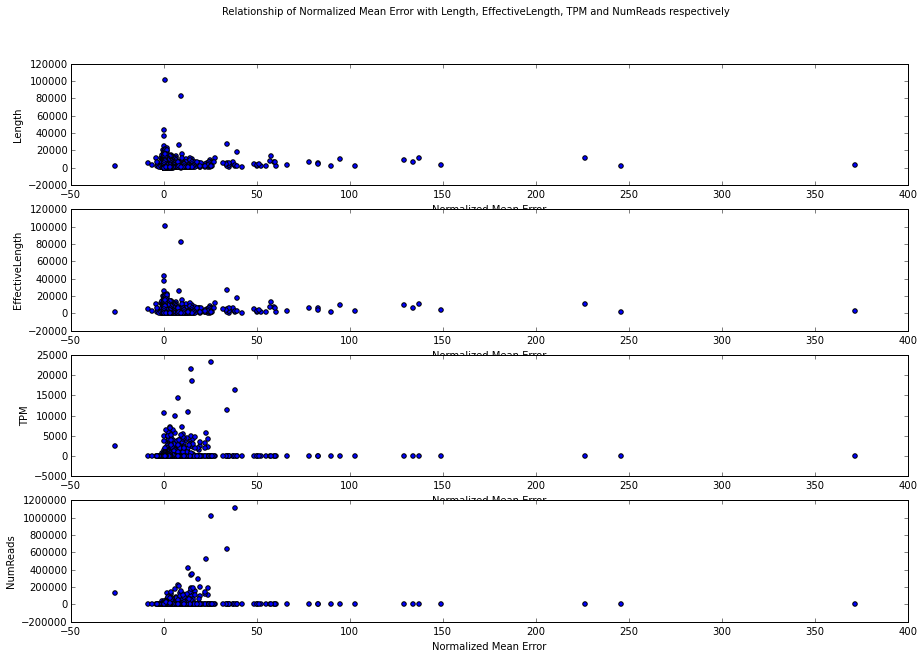

In [135]:
fig, axs = plt.subplots(4,1)#, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

for i, prop in enumerate(properties):
    axs[i].scatter(data['mae_n'], data[prop])
    axs[i].set_xlabel('Normalized Mean Error')
    axs[i].set_ylabel('%s'%prop)
t = plt.suptitle('Relationship of Normalized Mean Error with Length, EffectiveLength, TPM and NumReads respectively')

Zooming into the dense region of the above graphs.

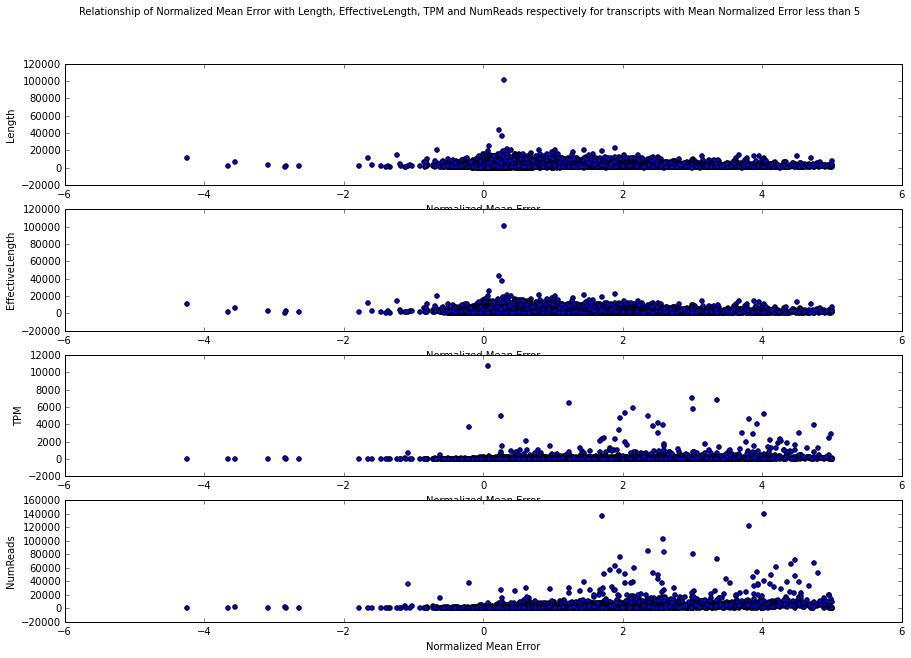

In [136]:
fig, axs = plt.subplots(4,1)#, sharey=True, sharex=True)
fig.set_size_inches(15,10)

properties = ['Length', 'EffectiveLength', 'TPM', 'NumReads']

filtered = data[np.abs(data['mae_n']) < 5]

for i, prop in enumerate(properties):
    axs[i].scatter(filtered['mae_n'], filtered[prop])
    axs[i].set_xlabel('Normalized Mean Error')
    axs[i].set_ylabel('%s'%prop)

t = plt.suptitle('Relationship of Normalized Mean Error with Length, EffectiveLength, TPM and NumReads respectively for \
transcripts with Mean Normalized Error less than 5')

Most number of Transcripts have a very small mean absolute percentage error as shows in above figure.

<hr>
[Go to top](#toc)
<a id="makeupeclasses"></a>
### 2.L. Valid and invalid transcripts are often found together in equivalent classes

We tried to find out how the **invalid** transcripts are distributed in the **equivalence classes**. More importantly, do all the invalid transcripts are grouped in same equivalence classes?
The plot below shows that the **invalid** equivalence classes occur even with valid transcripts in equivalence classes.

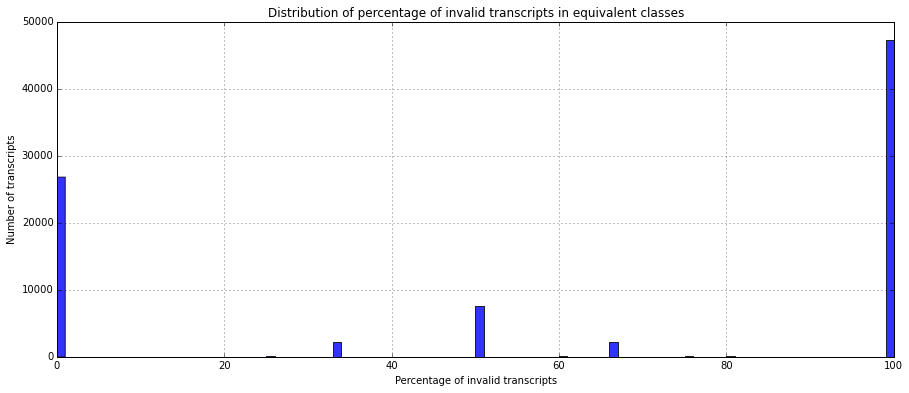

In [155]:
merged.groupby('eclass_id').apply(lambda x: 100*float(sum(x['invalid']))/len(x)).hist(bins=100, alpha=0.8)
plt.xlabel('Percentage of invalid transcripts')
plt.ylabel('Number of transcripts')
t = plt.title('Distribution of percentage of invalid transcripts in equivalent classes')

<hr>
[Go to top](#toc)
<a id="noofclasses"></a>
### 2.M. Number of equivalent classes valid and invalid transcripts belong to 

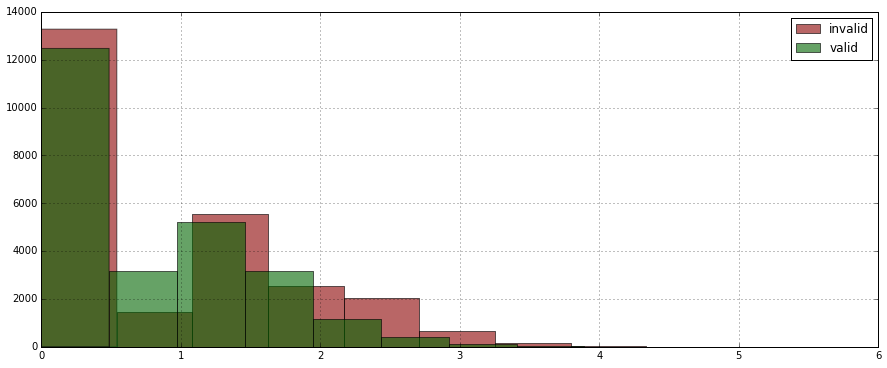

In [46]:
merged.groupby('transcript').apply(lambda x: x[x['invalid']]['eclass_id'].unique().shape[0]).apply(lambda x: log(x+1)).hist(alpha=0.6, color='darkred')
merged.groupby('transcript').apply(lambda x: x[~x['invalid']]['eclass_id'].unique().shape[0]).apply(lambda x: log(x+1)).hist(alpha=0.6, color='darkgreen')
plt.legend(['invalid', 'valid'])

<hr>
[Go to top](#toc)
<a id="weightedreads"></a>
### 2.N. Sum of numreads weighted by size of equivalent classes it belongs to

Digging deeper into equivalence classes, we tried to give each transcript a weight based on the average number of reads that come from it. To calculate the weight, we use the below formula.

Suppose transcript **$T_{1}$** appears in equivalence classes **$E_{1}$** and **$E_{2}$**. Class **$E_{1}$** has number of reads **$R_{1}$** and class **$E_{2}$** has number of reads **$R_{2}$** with number of members **$N_{1}$** and **$N_{2}$** respectively. So:

Weight of **$T_{1}$** = **($R_{1}$/$N_{1}$ + $R_{2}$/$N_{2}$)**

In [14]:
weightedreads = merged.groupby('transcript').apply(lambda x: sum(x['numreads'])/sum(x['eclass_size']))

In [15]:
weightedreads = pd.DataFrame(weightedreads, columns=['wread'])
weightedreads['invalid'] = data['invalid']
# weightedreads['NumReads'] = data['NumReads']

In [16]:
weightedreads['NumReads'] = data['NumReads']

In [17]:
wreads_merged = pd.merge(weightedreads, data[['NumReads']], left_index=True, right_index=True)

In [20]:
wr_merged = pd.merge(data, weightedreads, left_index=True, right_index=['transcript'])#right_on

In [24]:
wr_merged.head()

,0,1,2,3,4,5,6,7,8,9,...,std,mape,mae_n,Length,EffectiveLength,TPM,NumReads_x,wread,invalid_y,NumReads_y
ENST00000000233,407.872828,409.479633,414.335016,416.599248,421.485963,426.244825,426.349039,427.593225,430.844236,434.760516,...,23.706928,29.102825,1.448543,1103,903.991,16.010458,470.299697,418,True,470.299697
ENST00000002125,50.807511,54.765305,62.549450,72.059778,72.300058,73.719988,76.112339,76.172112,76.693547,76.958905,...,19.407230,19.664535,0.224625,2176,1976.991,1.717921,110.360787,7,False,110.360787
ENST00000002165,287.128089,296.887641,297.117566,300.269196,300.550772,302.278036,302.458390,302.807390,305.754256,307.689280,...,21.258426,8.652885,0.281415,2356,2156.991,4.886853,342.518910,96,False,342.518910
ENST00000002596,0.000000,3.000000,3.000000,3.000000,3.116178,3.116178,3.116178,3.116178,3.116178,3.116178,...,3.006401,0.149806,0.000631,8031,7831.991,0.032652,8.309809,2,False,8.309809
ENST00000003302,33.358214,33.358221,66.716430,66.716433,66.716433,66.716441,100.074652,109.772273,116.336115,133.133795,...,22.210581,17.367748,0.201273,4669,4469.991,1.089627,158.267455,4,True,158.267455


In [28]:
plt.rcParams['figure.figsize'] = (15, 6) 

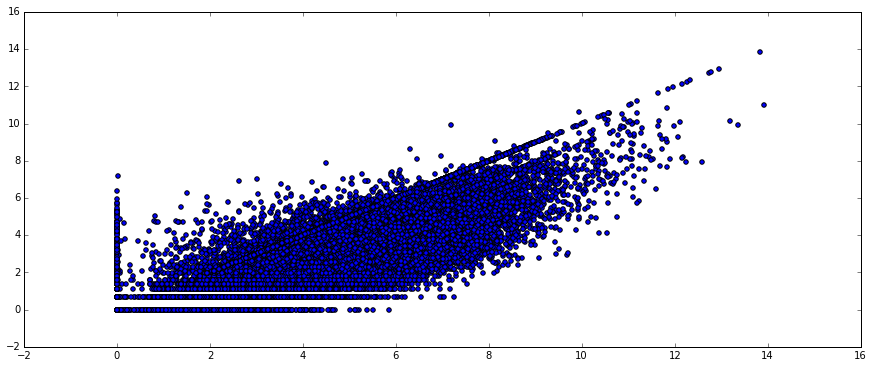

In [29]:
plt.scatter(wr_merged['NumReads_x'].apply(lambda x: log(x+1)), wr_merged['wread'].apply(lambda x: log(x+1)))

In [183]:
invalid = weightedreads[weightedreads['invalid']]
valid = weightedreads[~weightedreads['invalid']]

<hr>
[Go to top](#toc)
<a id="something"></a>
## 2.O. Sum of NumReads divided by Number of Equivalent Classes

In [ ]:
valid = merged[~merged['invalid']]
valid = merged[merged['invalid']]

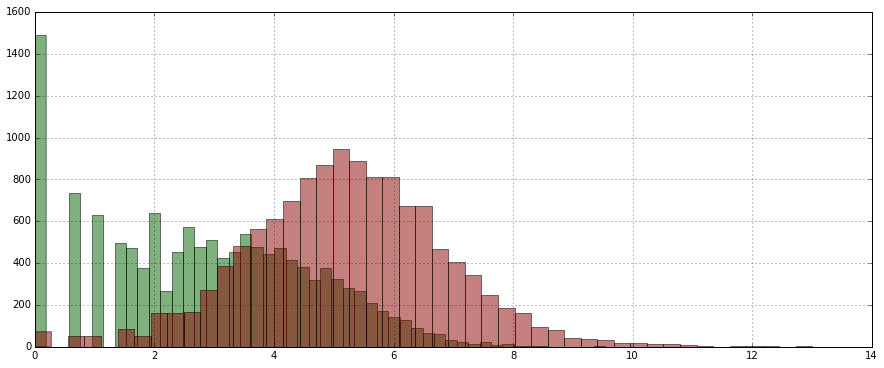

In [140]:
valid.groupby('transcript').apply(lambda x: sum(x['numreads'])/len(x)).apply(log).hist(alpha=0.5, bins=50, color='darkgreen')
invalid.groupby('transcript').apply(lambda x: sum(x['numreads'])/len(x)).apply(log).hist(alpha=0.5, bins=50, color='darkred')

In [190]:
# eq_df_uniques = eq_df[['eclass_id', 'eclass_len', 'overlap']].drop_duplicates()

# from math import log 

# plt.rcParams['figure.figsize'] = (15, 6)
# plt.scatter(eq_df_uniques['eclass_len'], eq_df_uniques['overlap'].apply(lambda x: log(x+1)), alpha=1, s=30)
# plt.grid()
# plt.xlabel('Length of equivalent classes')
# plt.ylabel('Overlap of equivalent classes')
# plt.title("Relationship between length and overlap of equivalent classes")
# plt.show()

In [ ]:
# eq_df[eq_df['eclass_len'] == 1]['overlap'].apply(log).hist()

In [191]:
# data[data['invalid']]['quality'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)
# data[~data['invalid']]['quality'].apply(lambda x: log(x+1)).hist(alpha=0.5, bins=100)

In [65]:
# eq_classes_count = eq_df.groupby('transcript').apply(lambda x: x['eclass_id'].unique().shape[0])

In [149]:
# eq_classes_count

<hr>
[Go to top](#toc)
<a id="classification"></a>

## 3. CLASSIFICATION

The code below gives the features we used for **classification** of **valid** and **invalid** transcripts and the scores we were able to obtain. Using **Support Vector Machines** (SVM) and the given features, we were able to predict if the transcript is valid or invalid with an f1-score of **0.81**!

In [144]:
grobj = merged2.groupby('transcript')

X_y = pd.DataFrame(index=set(merged2['transcript']))

X_y['num_classes'] = grobj.apply(lambda x: x['eclass_id'].unique().shape[0]).apply(log)

X_y['feature2'] = grobj.apply(lambda x: sum(x['eclass_size'])/len(x)).apply(log)
X_y['feature3'] = grobj.apply(lambda x: sum(x['eclass_size'])).apply(log)
X_y['feature4'] = grobj.apply(lambda x: sum(x['numreads'])/len(x)).apply(log)
X_y['weighted_reads'] = grobj.apply(lambda x: sum(x['numreads']/x['eclass_size'])).apply(log)
X_y['nu_other_trs'] = grobj.apply(lambda x: sum(x['eclass_size'])).apply(log)

X_y['avg_class_length'] = grobj.apply(lambda x: sum(x['Length'])/len(x)).apply(log)
X_y['avg_class_elength'] = grobj.apply(lambda x: sum(x['EffectiveLength'])/len(x)).apply(log)
X_y['avg_class_tpm'] = grobj.apply(lambda x: sum(x['TPM'])/len(x)).apply(lambda x: log(x+1))
X_y['avg_class_numreads'] = grobj.apply(lambda x: sum(x['NumReads'])/len(x)).apply(lambda x: log(x+1))

X_y['min'] = data_mins
X_y['maxs'] = data_maxs
X_y['mean'] = data_means
X_y['std'] = data_std

X_y['truth'] = data['truth']
X_y['invalid'] = data['invalid']
X_y['mape'] = data['mape']
X_y['mae_n'] = data['mae_n']

<a id="binaryclassification"></a>
### 3.A. Predicting valid/invalid transcripts using binary classification

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score 
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR

X = X_y[X_y.columns[:-4]]
y_mape = X_y['mape']
y_mae_n = X_y['mae_n']
y_truth = X_y['truth']
y_invalid = X_y['invalid']

X_s = pd.DataFrame(scale(X), columns=X.columns)

X_s, y_invalid = shuffle(X_s, y_invalid)

X_train, X_test, y_train, y_test = train_test_split(X_s, y_invalid, test_size=0.3)

# clf = LinearRegression()
# clf = SVR()
clf = SVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
# mean_squared_error(y_test, pred), r2_score(y_test, pred)
print classification_report(y_test, pred)

             precision    recall  f1-score   support

      False       0.80      0.84      0.82      3947
       True       0.82      0.79      0.80      3781

avg / total       0.81      0.81      0.81      7728



<hr>
[Go to top](#toc)
<a id="regression"></a>

### 2.B. Predicting mean error using regression

The code below is for predicting the normalized mean absolute error using the same features. 

For the regression, we used Linear Regression and Support Vector Regressor (SVR). We obtained better results using SVR.

Mean Squared Error and R-square values obtained are given. 

In [148]:
X_s = pd.DataFrame(scale(X), columns=X.columns)

X_s, y_mae_n = shuffle(X_s, y_mae_n)

X_train, X_test, y_train, y_test = train_test_split(X_s, y_mae_n, test_size=0.3)

# clf = LinearRegression()
clf = SVR()
# clf = SVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
mean_squared_error(y_test, pred), r2_score(y_test, pred)
# print classification_report(y_test, pred)

(12.596414461155168, 0.058838598493201721)

##